<a href="https://colab.research.google.com/github/adventurousAyan/AyanRepo/blob/master/Model_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import gc
import os
import random

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

path_data = "/content/drive/MyDrive/Colab Notebooks/datasets/"
path_train = path_data + "train_data.csv"
path_test = path_data + "test_data.csv"
path_building = path_data + "farm_data.csv"
path_weather_train = path_data + "train_weather.csv"
path_weather_test = path_data + "test_weather.csv"

plt.style.use("seaborn")
sns.set(font_scale=1)

myfavouritenumber = 0
seed = myfavouritenumber
random.seed(seed)

In [4]:
df_train = pd.read_csv(path_train)

building = pd.read_csv(path_building)
le = LabelEncoder()
building.farming_company = le.fit_transform(building.farming_company)

weather_train = pd.read_csv(path_weather_train)

In [5]:
## Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
df_train = reduce_mem_usage(df_train, use_float16=True)
building = reduce_mem_usage(building, use_float16=True)
weather_train = reduce_mem_usage(weather_train, use_float16=True)

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.95 MB
Decreased by 71.8%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.07 MB
Decreased by -1.5%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


In [19]:
def prepare_data(X, building_data, weather_data, test=False):
    """
    Preparing final dataset with all features.
    """
    
    X = X.merge(building_data, on="farm_id", how="left")
    X = X.merge(weather_data, on=["deidentified_location", "timestamp"], how="left")
    
    X.timestamp = pd.to_datetime(X.timestamp, format="%Y-%m-%d %H:%M:%S")
    X.farm_area = np.log1p(X.farm_area)
    
    if not test:
        X.sort_values("timestamp", inplace=True)
        X.reset_index(drop=True, inplace=True)
    
    gc.collect()
    
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    
    X["hour"] = X.timestamp.dt.hour
    X["weekday"] = X.timestamp.dt.weekday
    #X["is_holiday"] = (X.timestamp.dt.date.astype("str").isin(holidays)).astype(int)
    
    drop_features = ["timestamp", "cloudiness", "dew_temp"]

    X.drop(drop_features, axis=1, inplace=True)

    if test:
        row_ids = X.id
        X.drop("id", axis=1, inplace=True)
        return X, row_ids
    else:
        y = np.log1p(X['yield'])
        X.drop("yield", axis=1, inplace=True)
        return X, y

In [7]:
df_train.columns

Index(['date', 'farm_id', 'ingredient_type', 'yield'], dtype='object')

In [8]:
df_train.columns = ['timestamp', 'farm_id', 'ingredient_type', 'yield']

In [13]:
X_train, y_train = prepare_data(df_train, building, weather_train)

del df_train, weather_train
gc.collect()

35

In [14]:
X_half_1 = X_train[:int(X_train.shape[0] / 2)]
X_half_2 = X_train[int(X_train.shape[0] / 2):]

y_half_1 = y_train[:int(X_train.shape[0] / 2)]
y_half_2 = y_train[int(X_train.shape[0] / 2):]

categorical_features = ["farm_id", "deidentified_location", "ingredient_type", "farming_company", "hour", "weekday"]

d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

print("Building model with first half and validating on second half:")
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=1000, valid_sets=watchlist_1, verbose_eval=200, early_stopping_rounds=200)

print("Building model with second half and validating on first half:")
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=1000, valid_sets=watchlist_2, verbose_eval=200, early_stopping_rounds=200)

Building model with first half and validating on second half:


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.976036	valid_1's rmse: 1.38862
[400]	training's rmse: 0.9135	valid_1's rmse: 1.3791
[600]	training's rmse: 0.885585	valid_1's rmse: 1.37587
Early stopping, best iteration is:
[562]	training's rmse: 0.890523	valid_1's rmse: 1.37538
Building model with second half and validating on first half:
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.954732	valid_1's rmse: 1.52312
[400]	training's rmse: 0.905674	valid_1's rmse: 1.51197
[600]	training's rmse: 0.884596	valid_1's rmse: 1.50932
[800]	training's rmse: 0.869462	valid_1's rmse: 1.50792
[1000]	training's rmse: 0.857499	valid_1's rmse: 1.50676
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.857499	valid_1's rmse: 1.50676


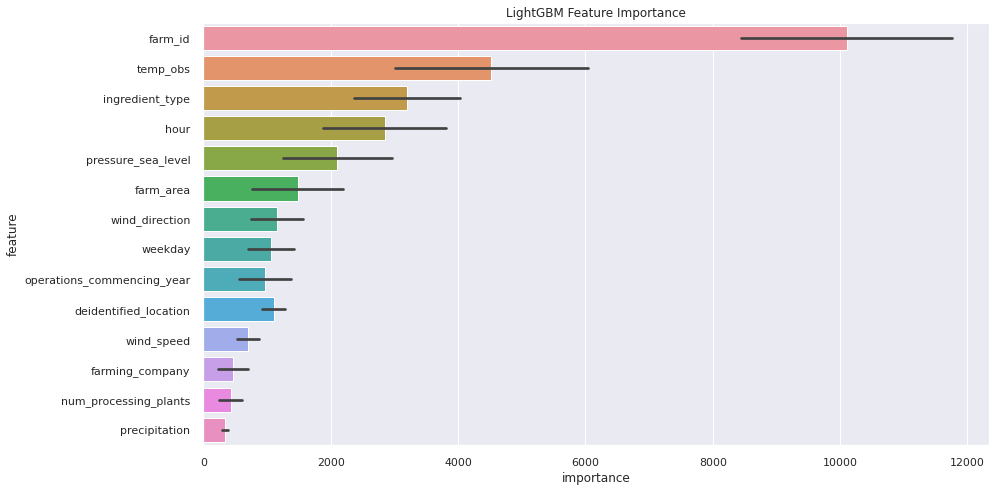

In [15]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_train.columns.values
df_fimp_1["importance"] = model_half_1.feature_importance()
df_fimp_1["half"] = 1

df_fimp_2 = pd.DataFrame()
df_fimp_2["feature"] = X_train.columns.values
df_fimp_2["importance"] = model_half_2.feature_importance()
df_fimp_2["half"] = 2

df_fimp = pd.concat([df_fimp_1, df_fimp_2], axis=0)

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

In [17]:
df_test.columns

Index(['date', 'farm_id', 'ingredient_type', 'id'], dtype='object')

In [ ]:
#

In [20]:
df_test = pd.read_csv(path_test)
weather_test = pd.read_csv(path_weather_test)

df_test = reduce_mem_usage(df_test)
df_test.columns = ['timestamp', 'farm_id', 'ingredient_type', 'id']
weather_test = reduce_mem_usage(weather_test)

X_test, row_ids = prepare_data(df_test, building, weather_test, test=True)

Memory usage of dataframe is 636.26 MB
Memory usage after optimization is: 179.38 MB
Decreased by 71.8%
Memory usage of dataframe is 9.53 MB
Memory usage after optimization is: 4.48 MB
Decreased by 53.0%


In [21]:
pred = np.expm1(model_half_1.predict(X_test, num_iteration=model_half_1.best_iteration)) / 2

del model_half_1
#gc.collect()

pred += np.expm1(model_half_2.predict(X_test, num_iteration=model_half_2.best_iteration)) / 2
    
del model_half_2
#gc.collect()

In [22]:
submission = pd.DataFrame({"id": row_ids, "yield": np.clip(pred, 0, a_max=None)})
submission.to_csv("/content/drive/MyDrive/Colab Notebooks/datasets/Model_LGBM.csv", index=False)

In [23]:
submission.shape

(21251760, 2)

In [24]:
submission.id.nunique()

20848800